# Практический проект по использованию tf-idf
# Цель
В этом задании вам предстоит поработать с методом tf-idf чтобы извлечь признаки из текста для построения моделей.

1. Скачайте данные по отзывам с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

2. Разбейте данные на train/test, отложив 30% наблюдений для тестирования (датасет достаточно большой и выборка сбалансированная, так что можно не беспокоиться о стратификации)

3. Примените tf-idf преобразование. Используйте как отдельные токены, так и биграммы, отсейте английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов (параметры min/max_df)

4. Постройте логистическую регрессию со стохастическим градиентным спуском, оцените качество по accuracy

5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Какие слова наиболее характерны для отрицательных отзывов? Какие для положительных? 

# EDA

In [7]:
import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import json

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import seaborn as sn
from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [9]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Посмотрим на текст отзыва, а также на возможные "лишние" символы в тексте.

In [10]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

# 1.  Анализ текста

Для очистки текста необходимо удалить html-теги и кавычки.

Для этого напишем функцию:

In [4]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def preprocess_text(text):
    text_removed_slashes = text.replace("\'","")
    text_removed_tags = TAG_RE.sub('', text_removed_slashes)
    text_to_lower_case = str.lower(text_removed_tags)
    return text_to_lower_case

Посмотрми на распределение коментариев по окраске.

In [5]:
df.sentiment.apply(lambda s: 1 if s == 'positive' else 0).value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

Отлично коментариии распределены равномерно.

Также посмотрим на пропуски в данных.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

В данных нет пропусков.

Покажем графически распределение размеров коментариев.

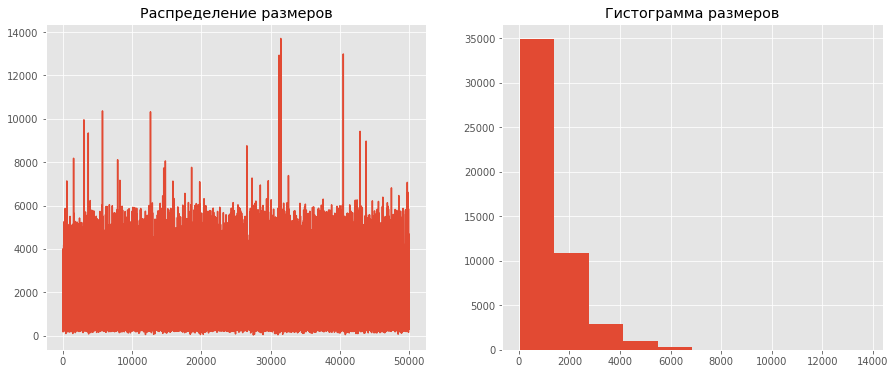

In [8]:
size_data = df['review'].apply(lambda r: len(r))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(size_data)
ax1.set_title('Распределение размеров')


ax2.hist(size_data)
ax2.set_title('Гистограмма размеров')
plt.show()

# 2. Подготовка тестовых данных

Разделим выборку на тренировочную и тестовую.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['review'], 
    df['sentiment'], 
    test_size=0.33,
    random_state=42,
    stratify=df['sentiment']
)

print('Размер полной выборки:        ',df.shape[0])
print('Распределение позитивных/негативных:')
print(df.sentiment.value_counts())
print()
print('Размер тренировочной выборки: ',X_train.shape[0])
print('Распределение позитивных/негативных:')
print(y_train.value_counts())
print()


print('Размер тестовой выборки:      ',X_test.shape[0])
print('Распределение позитивных/негативных:')
print(y_test.value_counts())
print()

Размер полной выборки:         50000
Распределение позитивных/негативных:
positive    25000
negative    25000
Name: sentiment, dtype: int64

Размер тренировочной выборки:  33500
Распределение позитивных/негативных:
negative    16750
positive    16750
Name: sentiment, dtype: int64

Размер тестовой выборки:       16500
Распределение позитивных/негативных:
negative    8250
positive    8250
Name: sentiment, dtype: int64



# 3. Преобразование данных

Импортируем английские стоп-слова и стеммер.

In [2]:
import nltk
from nltk.corpus import stopwords

stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

Создадим классы для преобразования коментариев.

In [17]:
"""
TAG_RE = re.compile(r'<[^>]+>')

def preprocess_text(text):
    text_removed_slashes = text.replace("\'","")
    text_removed_tags = TAG_RE.sub('', text_removed_slashes)
    text_to_lower_case = str.lower(text_removed_tags)
    return text_to_lower_case
"""
from sklearn.base import BaseEstimator, TransformerMixin
import re
import nltk
from nltk.corpus import stopwords

class ColumnSelector(BaseEstimator,TransformerMixin):
    def __init__(self, columns: list):
        self.cols = columns

    def fit(self,X,y=None):
        return self

    def transform(self, X, y=None):
        return X.loc[:, self.cols]
    
class TagsTextTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.TAG_RE = re.compile(r'<[^>]+>')
    
    def _preprocess_text(self,text):
        text_removed_slashes = text.replace("\'","")
        text_removed_open_braket = text_removed_slashes.replace("(","")
        text_removed_close_braket = text_removed_open_braket.replace(")","")
        text_removed_tags = self.TAG_RE.sub('', text_removed_close_braket)
        text_to_lower_case = str.lower(text_removed_tags)
        return text_to_lower_case

    def transform(self, X,y=None):
        return X.apply(lambda t: self._preprocess_text(t))
    
    def fit(self,X,y=None):
        return self
    
class TextStemmer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.stop = stopwords.words('english')
        self.stemmer = nltk.stem.snowball.EnglishStemmer('english')

    def _data_Stemmer(self, text):
        return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])
    
    def transform(self, X,y=None):
        return X.apply(lambda t: self._data_Stemmer(t))
    
    def fit(self,X,y=None):
        return self

# 4. Обучение модели

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

Очистим и преобразуем наши данные для последующего обучения.

In [23]:
%%time
ttt = TagsTextTransformer()
ts = TextStemmer()
tfidf = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=3/X_train.shape[0], max_df=0.5, norm='l2')
clf = SGDClassifier(loss='log', shuffle=True, n_iter_no_change=10, max_iter=1000, penalty='l2', random_state=42)

X_train_tfd = X_train
y_train_tfd = y_train

X_train_tfd = ttt.transform(X_train_tfd)
X_train_tfd = ts.transform(X_train_tfd)
X_train_tfd = tfidf.fit_transform(X_train_tfd)
y_train_tfd = y_train_tfd.map({'positive': 1, 'negative': 0})

CPU times: user 1min 46s, sys: 1.52 s, total: 1min 48s
Wall time: 1min 50s


Обучим модель.

In [65]:
%%time
clf.fit(X_train_tfd, y_train_tfd,)

CPU times: user 778 ms, sys: 73.9 ms, total: 852 ms
Wall time: 734 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=10, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Предскажем окраску коментариев по тестовой выборке.

In [25]:
X_test_tfd = X_test
y_test_tfd = y_test

X_test_tfd = ttt.transform(X_test_tfd)
X_test_tfd = ts.transform(X_test_tfd)
X_test_tfd = tfidf.transform(X_test_tfd)
score = clf.predict(X_test_tfd)

In [26]:
y_test_tfd = y_test_tfd.map({'positive': 1, 'negative': 0})

# 5. Проверка качества

Посмотрим на получившиеся качество.

In [28]:
print(classification_report(score, y_test_tfd))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      7973
           1       0.90      0.87      0.88      8527

    accuracy                           0.88     16500
   macro avg       0.88      0.88      0.88     16500
weighted avg       0.88      0.88      0.88     16500



Неплохое качество, визуализируем результаты.

In [68]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=50):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

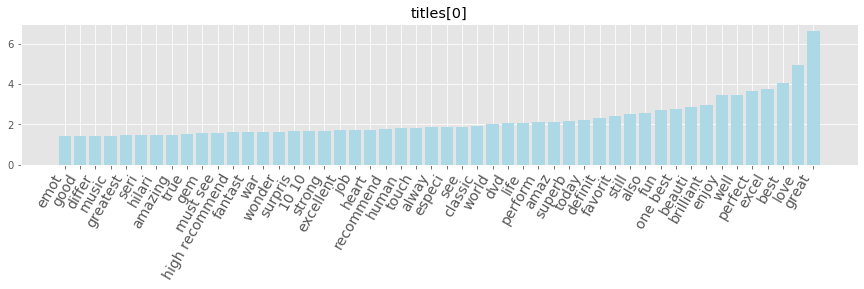

In [69]:
visualize_coefficients(clf.coef_[0,:], tfidf.get_feature_names(),title='titles[0]', plot_num=0)

Построим ТОП-50 негативных и позитивных слов.

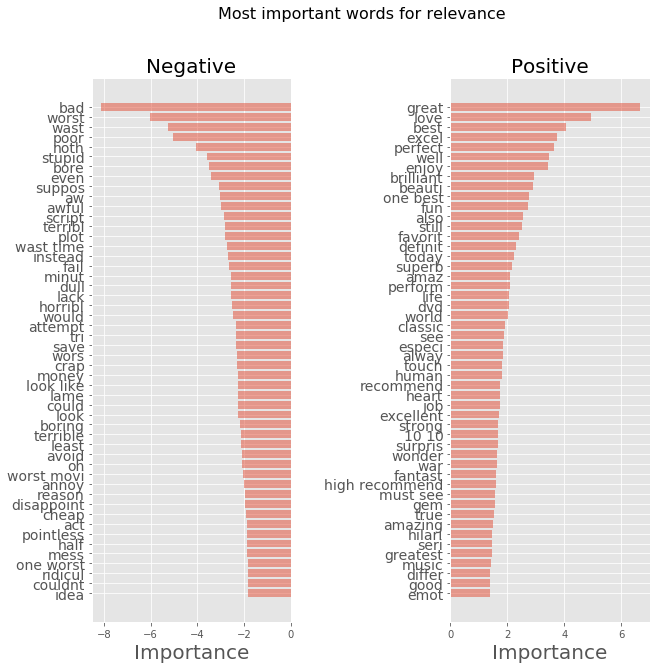

In [90]:
from sklearn.feature_extraction.text import CountVectorizer

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(tfidf, clf, 50)

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Выводы

В данной работе была создана модель логистической регрессии со стохастическим градиентным спуском над тестовым датасетом коментариев IMBD.

Модель показала неплохое качество, а также позволила визуализировать ТОП-5 позитивных и негативных коментариев.